In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler # Used for scaling of data
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [5]:
# Read in train data
df_train = pd.read_csv('train(1).csv',index_col=0)

In [6]:
df_train.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
Id                                    ...                             
1          Lvl    AllPub    Inside    ...            0    NaN   NaN   
2          Lvl    AllPub       FR2    ...            0    NaN   NaN   
3          Lvl    AllPub    Inside    ...            0    NaN   NaN   
4          Lvl    AllPub    Corner    ...            0    NaN   NaN   
5          Lvl    AllPub       FR2    ...            0    NaN   NaN   

   MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                                         
1          NaN       0      2    2008        WD         Normal     208500  
2          NaN       0      5    2007        WD         Normal     181500  
3          NaN       0      9    2008        WD         Normal     223500  
4          NaN       0      2    2006        WD        Abnorml     140000  
5          NaN       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

# Prepare data
    Investigate what data that has a linear or some kind of relation to the sale price
    Drop the unimportant features or less unimportant features
    Drop features which has many NaN values

In [7]:
#descriptive statistics summary
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


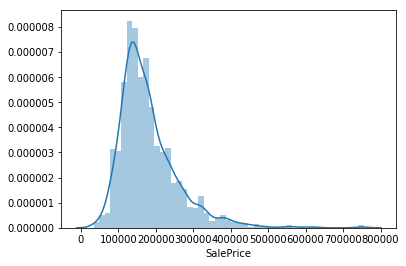

In [8]:
#histogram
sns.distplot(df_train['SalePrice']);

In [9]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


    - Skewness means the top of the iceberg is not in the middle but rather towards left or right.
    - Kurtosis describe if the gaussian distrubution is very small and narrow or very wide

Use a heatmap to see which features have strongest correlation with house price

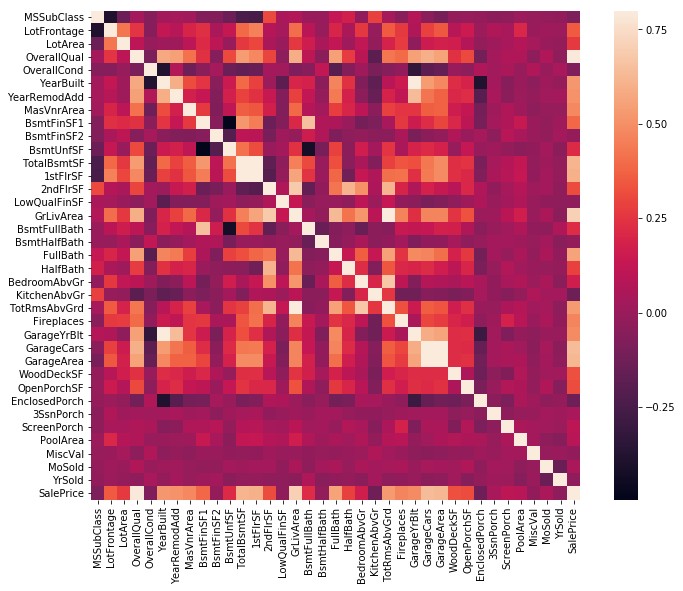

In [10]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

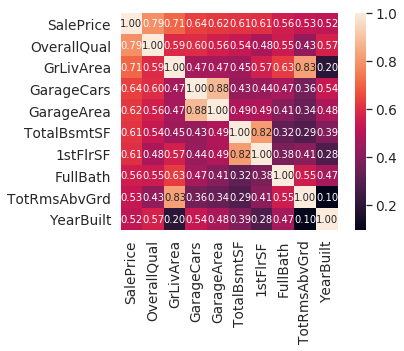

In [11]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

From this plot we can draw the conclusion that:
    - OverallQual is important
    - GrLivArea is also important
    - TotalBsmtSF is important
    - GarageCars and GarageArea are two important features but we drop GarageArea since it is more or less the same information as GarageCars
    - TotalBsmtSF and 1stFlrSF are also more or less the same so we drop 1StFlrSF
    - TotRmsAbvGrd and GrLivArea are also strongly correlated to let's drop TotRmsAbvGrd
 
 Let's scatterplot these important features.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


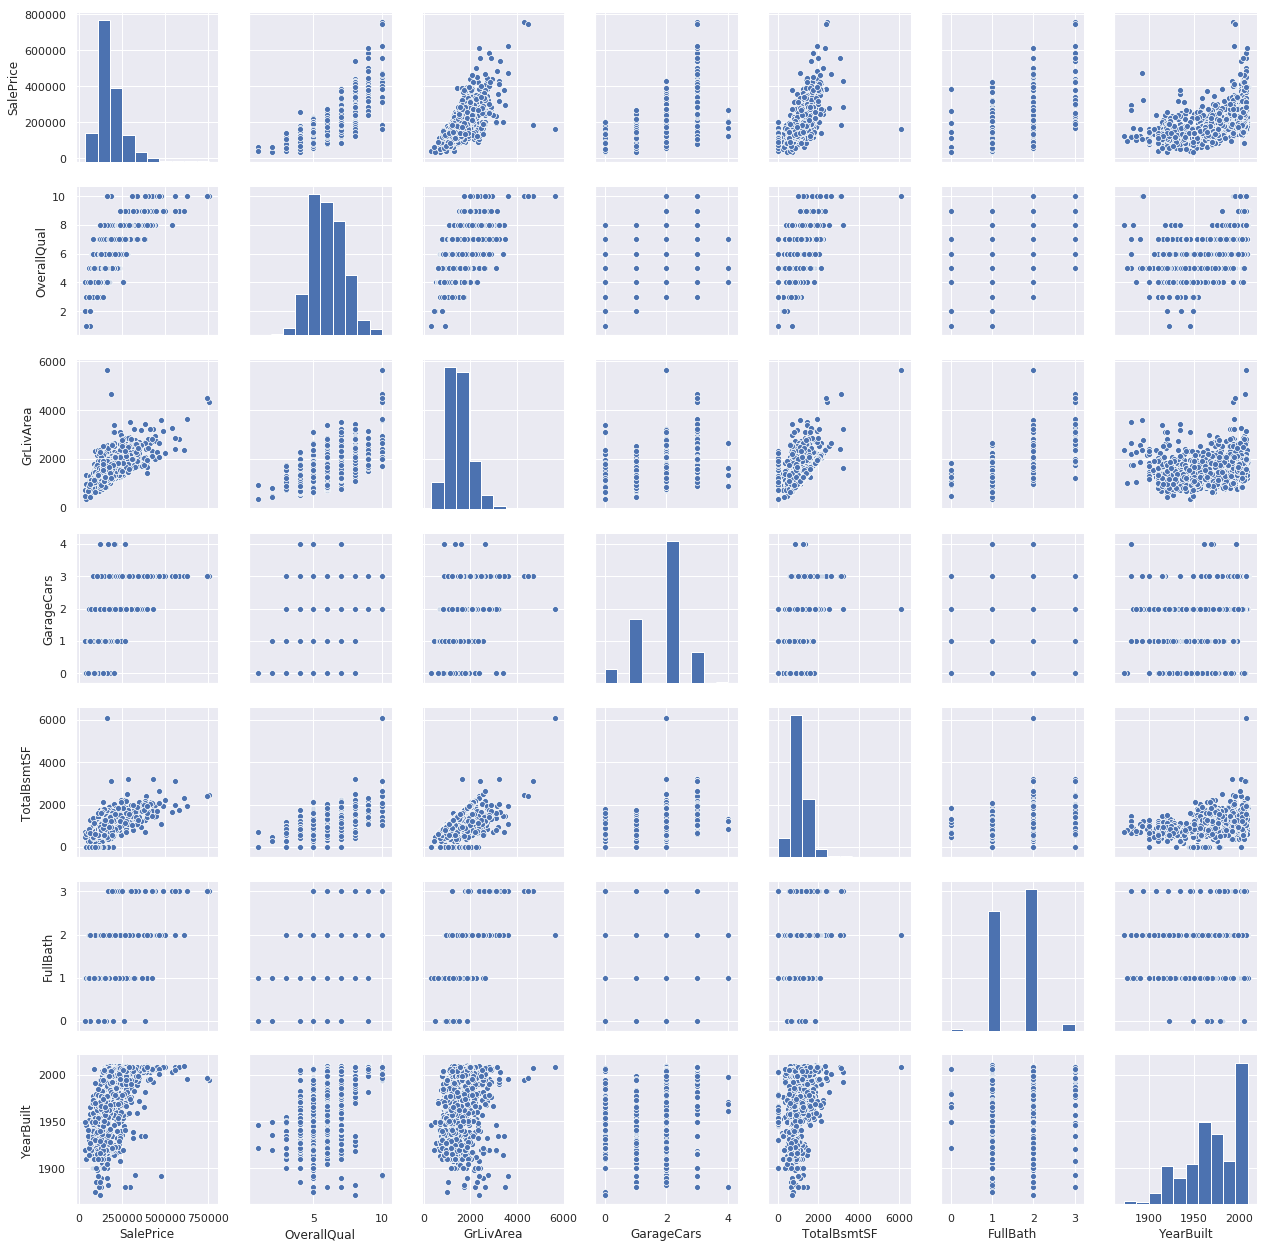

In [12]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

The basement area and total living area seems to have similarities their saleprice plot looks almost identical, let's drop basement area.

Maybe also remove year built data since this data can be tricky to use.

Let's have a  look at the missing data.

Let's display a % of the data that is missing from some columns.

In [14]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageType       81  0.055479
GarageCond       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
GarageYrBlt      81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
RoofMatl          0  0.000000

df_train = df_train.fillna(df_train.mean())

In [16]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [20]:
df_train = pd.read_csv('train.csv')

In [21]:
cols = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
df_train = df_train[cols]
# Create dummy values
df_train = pd.get_dummies(df_train)
#filling NA's with the mean of the column:
df_train = df_train.fillna(df_train.mean())
# Always standard scale the data before using NN
scale = StandardScaler()
X_train = df_train[['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']]
X_train = scale.fit_transform(X_train)
# Y is just the 'SalePrice' column
y = df_train['SalePrice'].values
seed = 7
np.random.seed(seed)
# split into 67% for train and 33% for test
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.33, random_state=seed)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [22]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_squared_error', 
              metrics =[metrics.mae])
    return model

In [23]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 1,671
Trainable params: 1,671
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=150, batch_size=32)

Train on 978 samples, validate on 482 samples
Epoch 1/150
978/978 [==============================] - 2s 2ms/step - loss: 38028810327.9509 - mean_absolute_error: 179315.7656 - val_loss: 41089226008.4315 - val_mean_absolute_error: 184177.9219
Epoch 2/150
978/978 [==============================] - 0s 311us/step - loss: 38028382928.3599 - mean_absolute_error: 179314.5625 - val_loss: 41088485422.7386 - val_mean_absolute_error: 184175.9531
Epoch 3/150
978/978 [==============================] - 0s 263us/step - loss: 38027064552.4417 - mean_absolute_error: 179310.8750 - val_loss: 41086103428.7801 - val_mean_absolute_error: 184169.5312
Epoch 4/150
978/978 [==============================] - 0s 252us/step - loss: 38023135709.4479 - mean_absolute_error: 179299.7812 - val_loss: 41079452361.8257 - val_mean_absolute_error: 184151.6094
Epoch 5/150
978/978 [==============================] - 0s 256us/step - loss: 38012754594.2904 - mean_absolute_error: 179270.5781 - val_loss: 41063209516.6141 - val_mean

978/978 [==============================] - 0s 293us/step - loss: 2280783599.2474 - mean_absolute_error: 33781.3594 - val_loss: 1987646133.9087 - val_mean_absolute_error: 33354.3516
Epoch 85/150
978/978 [==============================] - 0s 277us/step - loss: 2262759833.6524 - mean_absolute_error: 33586.5703 - val_loss: 1961213911.9004 - val_mean_absolute_error: 33095.1250
Epoch 86/150
978/978 [==============================] - 0s 314us/step - loss: 2241226402.5521 - mean_absolute_error: 33409.9922 - val_loss: 1949413795.7178 - val_mean_absolute_error: 32972.3672
Epoch 87/150
978/978 [==============================] - 0s 261us/step - loss: 2223631307.6483 - mean_absolute_error: 33246.2852 - val_loss: 1936093218.2573 - val_mean_absolute_error: 32819.9922
Epoch 88/150
978/978 [==============================] - 0s 231us/step - loss: 2205000713.6851 - mean_absolute_error: 33096.7109 - val_loss: 1921262985.4274 - val_mean_absolute_error: 32657.2949
Epoch 89/150
978/978 [=====================